In [1]:
import numpy as np
import pyDOE as doe
import pandas as pd
import math
from DataSampling import samplers
import os

In [ ]:
# Definition of features to sample
par_names = ['L', 'B', 'E_1', 'E_2', 'ms_fac', 'F', 's', 't_1', 't_2', 'nl', 'nu_1', 'nu_2', 'mat', 't/L']        
# L, B           [cm]        length, width (L=B, square plates)
# E_1, E_2       [MPa]       Young's modulus
# ms_fac         [-]         Mesh size factor
# F              [kN]        Force
# s              [-]         Scenario (type of Boundary conditions)
# t_1, t_2       [mm]        Thickness
# nl             [-]         Number of layers
# nu_1, nu_2     [-]         Poisson's ratio
# mat            [-]         Material type (1 = lin.el.steel; 10 = laminated glass, where index 1 = glass, index 2 = interlayer)
#                            if mat = 1: only E_1, t_1 and nu_1 will be used, E_2, t_2 and nu_2 will be neglected

# For glass:
# min = [30, 30, 70000, 0.003, 0.05, 20, 4, 2, 0.38, 7, 0.24, 0.499, 10]
# max = [325, 325, 71000, 0.006, 0.5, 30, 4, 25, 2.28, 7, 0.24, 0.499, 10]
# For steel:
min = [10, 10, 210000, 0, 0.05, 20, 8, 30, 0, 20, 0, 0, 1]
max = [100, 100, 210000, 0, 0.5, 30, 8, 200, 0, 20, 0, 0, 1]
# For reinforced concrete:
# min = [10, 10, 35, 205000, 0.05, 20, 4, 30, 0, 20, 0, 0, 3]
# max = [100, 100, 42, 205000, 0.5, 30, 4, 200, 0, 20, 0, 0, 3]
samples = 90
criterion = 'c'
# can be 'c', 'm', 'cm' or 'corr' (see here: https://pythonhosted.org/pyDOE/randomized.html)

save_folder = True
# if this is set to true, a new folder with outputfiles will be generated. if false, files will be overwritten in next run                                         



# Choosing sampler and sampling, converting to numpy array
lhs_sampler = samplers(par_names, min, max, samples, criterion) 
data = lhs_sampler.lhs()
np_data = data.to_numpy()

#convert data type to float
np_data = np.array(list(np_data), dtype=np.float64)


# Processing to correct units
np_data[:,0] = np.round(np_data[:,0], 1)
np_data[:,1] = np.round(np_data[:,1], 1)
np_data[:,0:2] = np_data[:,0:2]*10                                          # in mm as required for the program later

np_data[:,5] = np.round(np_data[:,5], 1)
np_data[:,5] = -np_data[:,4]*1000                                           # in N as required for the program later
for i in range(samples):                                                    # make sure that the force is never zero
    if np_data[i,5] == 0:
        np_data[i,5] = 1
    if np_data[i, 12] == 3:
        np_data[i, 2] = np.round(np_data[i,2], 1)                           # make sure that we only get steps of 0.1 between 35 and 42
        np_data[i, 2] = np_data[i, 2]*10**3                                 # convert to N/mm^2 as required by simulation
        

In [3]:
np.set_printoptions(suppress=True,precision=3)
print(np_data[0:10,:])

[[   245.       515.    210000.         0.         0.188   -187.5
       8.       127.278      0.        20.         0.         0.
       1.   ]
 [   405.       235.    210000.         0.         0.237   -237.5
       8.       189.611      0.        20.         0.         0.
       1.   ]
 [   855.       305.    210000.         0.         0.288   -287.5
       8.       172.611      0.        20.         0.         0.
       1.   ]
 [   125.       525.    210000.         0.         0.378   -377.5
       8.        44.167      0.        20.         0.         0.
       1.   ]
 [   225.       945.    210000.         0.         0.232   -232.5
       8.       149.944      0.        20.         0.         0.
       1.   ]
 [   315.       705.    210000.         0.         0.078    -77.5
       8.       123.5        0.        20.         0.         0.
       1.   ]
 [   325.       695.    210000.         0.         0.283   -282.5
       8.       106.5        0.        20.         0.         0.

In [4]:
# Data properties
print(np_data.shape)
np_data.dtype

(90, 13)


dtype('float64')

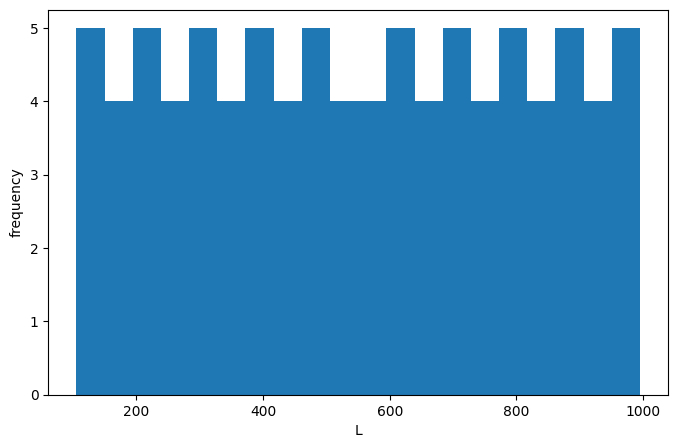

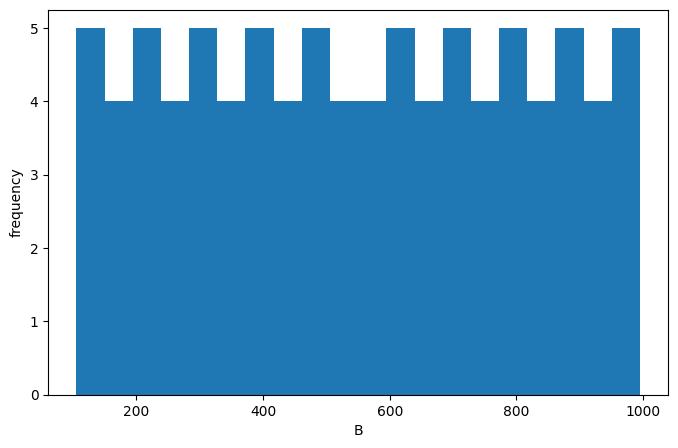

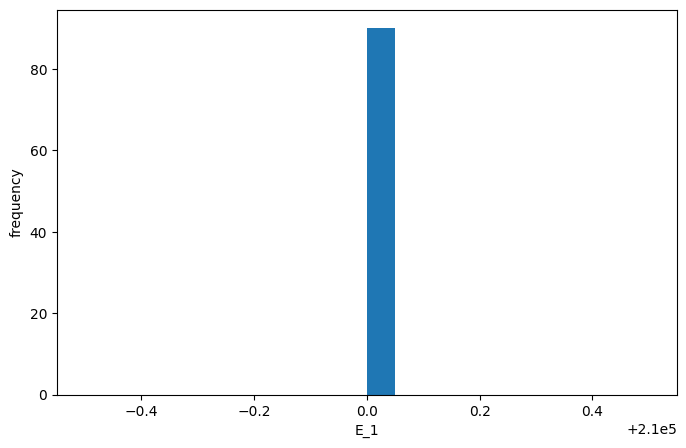

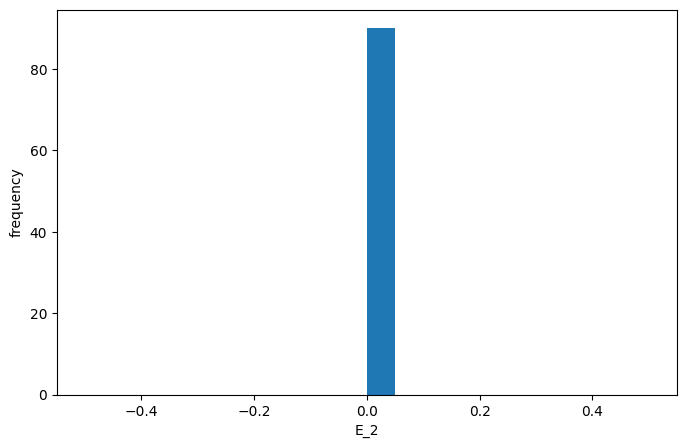

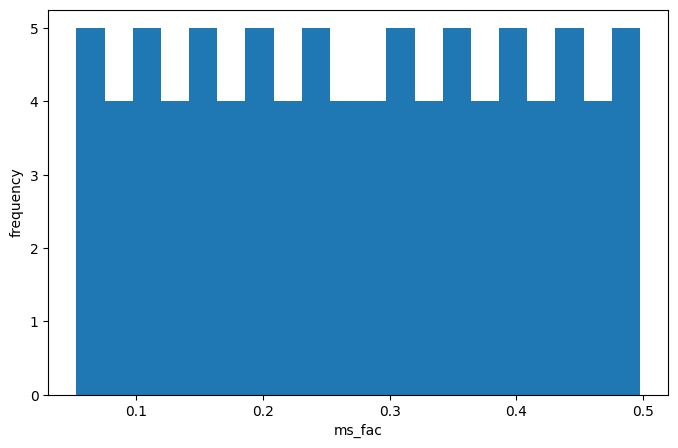

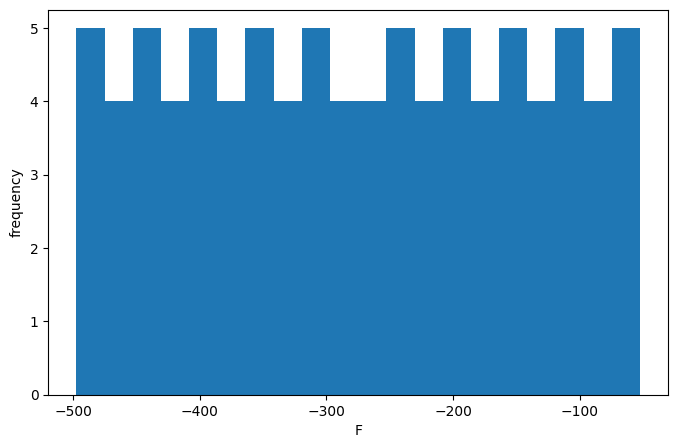

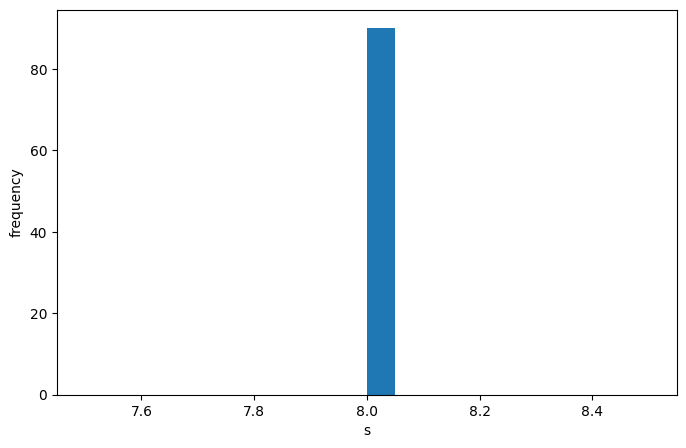

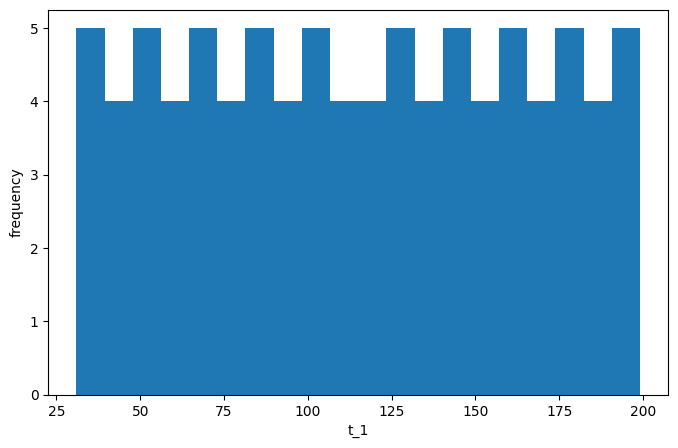

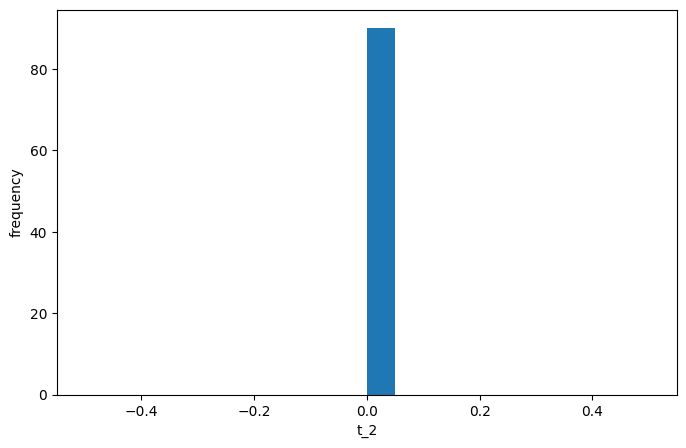

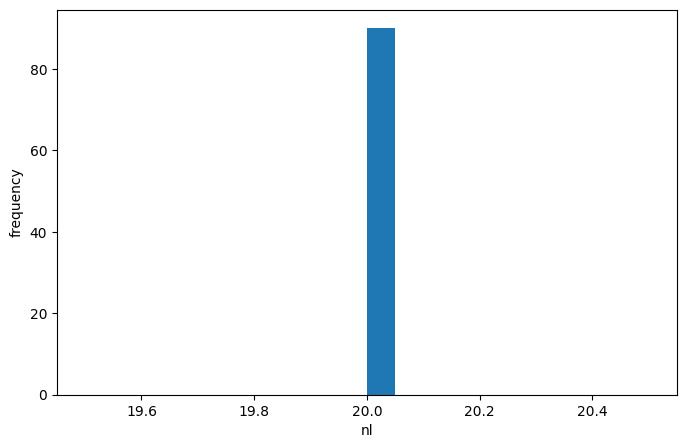

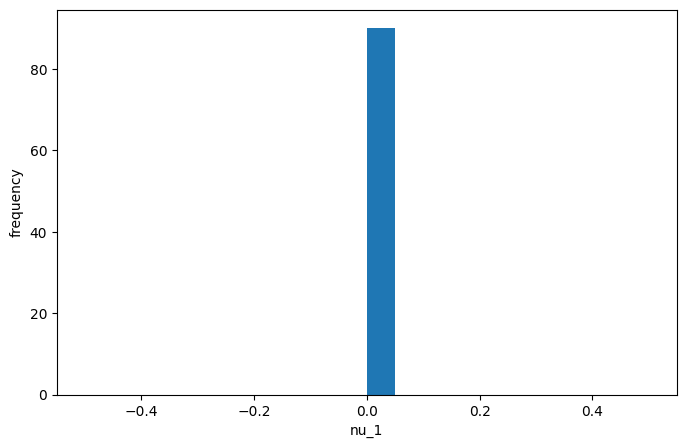

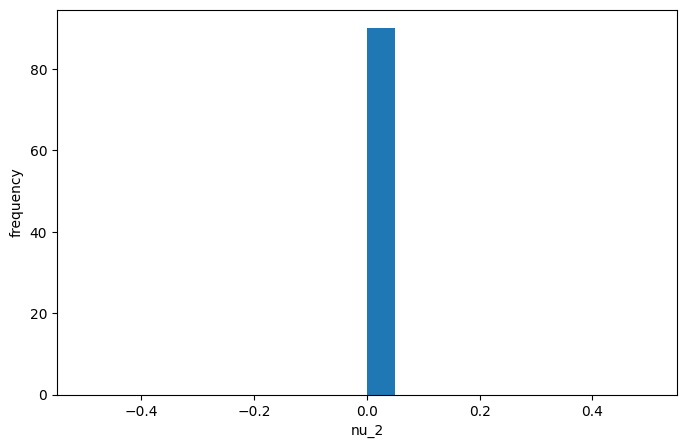

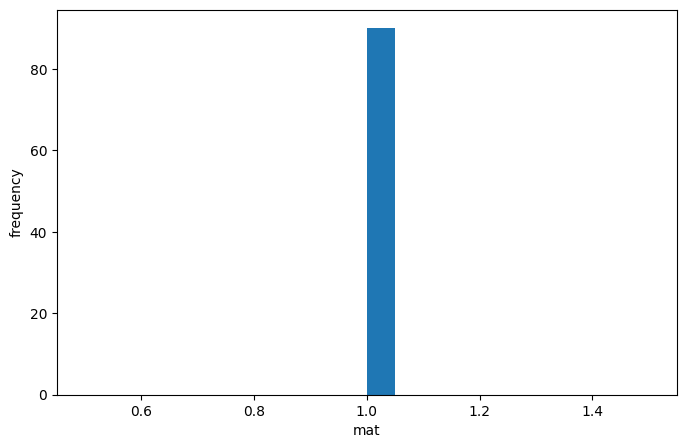

In [5]:
# Plotting histograms of sampled distributions

from DataSampling import plots
plot1 = plots(1)
path = r"C:\Users\vbalmer\Documents\GitHub\ShellSim\02_Simulator\Simulator\plots\input"

for i in range(np_data.shape[1]):
    plot1.histogram(np_data[:,i], 20, par_names[i], path)

In [6]:
## Changes to the data set, that might be adjusted later:

# Adding meshsize data, (simplified to L/2): 
# factor_x = 0.5
# np_data_extended = np.zeros((np_data.shape[0],np_data.shape[1]+1))
# np_data_extended[:,0:np_data.shape[1]] = np_data
# np_data_extended[:,np_data.shape[1]] = factor_x*(np_data[:,0])

# Adding meshsize data, for sampled mesh size
np_data_extended = np_data
np_data_extended[:,4] = np_data[:,0]*np_data[:,4]


# Making plates square (i.e. ignoring the sampled B, setting B = L, s.t. the elements have sizes of LxL):
np_data_extended[:,1] = np_data_extended[:,0]


print(np_data_extended)
print(np_data_extended.shape)
print(np_data_extended[:,0:5])

[[   245.    245. 210000. ...      0.      0.      1.]
 [   405.    405. 210000. ...      0.      0.      1.]
 [   855.    855. 210000. ...      0.      0.      1.]
 ...
 [   665.    665. 210000. ...      0.      0.      1.]
 [   365.    365. 210000. ...      0.      0.      1.]
 [   625.    625. 210000. ...      0.      0.      1.]]
(90, 13)
[[   245.       245.    210000.         0.        45.938]
 [   405.       405.    210000.         0.        96.188]
 [   855.       855.    210000.         0.       245.813]
 [   125.       125.    210000.         0.        47.188]
 [   225.       225.    210000.         0.        52.312]
 [   315.       315.    210000.         0.        24.413]
 [   325.       325.    210000.         0.        91.813]
 [   495.       495.    210000.         0.        33.413]
 [   705.       705.    210000.         0.       262.613]
 [   645.       645.    210000.         0.        66.113]
 [   285.       285.    210000.         0.       117.563]
 [   275.       2

In [7]:
# Saving data 

if np_data_extended[0,-1] == 1:
    np.save('outfile', np_data_extended)
    print('Saved sampled steel data')
elif np_data_extended[0,-1] == 10:
    np.save('outfile_glass', np_data_extended)
    print('Saved sampled glass data')
elif np_data_extended[0,-1] == 3:
    np.save('outfile_RC', np_data_extended)
    print('Saved sampled RC data')

Saved sampled steel data


In [8]:
from datetime import datetime
import shutil

if save_folder:
    if np_data_extended[0,-1] == 1:
        relative_path = 'outfile.npy'
    elif np_data_extended[0,-1] == 10:
        relative_path = 'outfile_glass.npy'
    elif np_data_extended[0,-1] == 3:
        relative_path = 'outfile_RC.npy'
    source_folder = os.path.dirname(relative_path)
    file_name = os.path.basename(relative_path)

    current_time = datetime.now()
    new_folder = current_time.strftime("data_%Y%m%d_%H%M_case"+str(int(np_data_extended[0,6])))
    new_folder_path = os.path.join(source_folder, new_folder)

    os.makedirs(new_folder_path, exist_ok=True)

    destination_path = os.path.join(new_folder_path, file_name)
    shutil.copy(relative_path, destination_path)

    print('File is copied to', destination_path)

File is copied to data_20241104_1545_case8\outfile.npy
